# Overfitting

How to overfit a model? That's quite easy, as you'll see. In this notebook we'll look into several "overfitting techniques" that are often used in practice.

## Setup

In [1]:
import datetime as dt
import itertools
import sys
import warnings

from loguru import logger
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_validate
from sklearn.inspection import permutation_importance
import shap

np.random.seed(42**3)

In [2]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [3]:
def ht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

## Simulating noise data

Let's simulate some data. Notice that targets and features are independent.

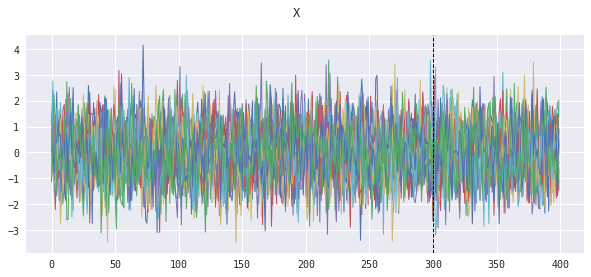

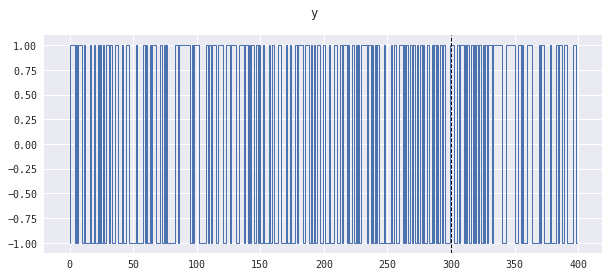

In [4]:
n_samples = 400
n_features = 20
train_size = 0.75
X = np.random.normal(size=(n_samples, n_features))
y = np.sign(np.random.normal(size=(n_samples)))
plt.figure(figsize=(10, 4))
plt.suptitle("X")
plt.plot(X)
plt.axvline(n_samples * train_size, ls="--", c="black")
plt.figure(figsize=(10, 4))
plt.suptitle("y")
plt.plot(y, drawstyle='steps-pre')
plt.axvline(n_samples * train_size, ls="--", c="black")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)

## Model definitions

If we model it fair and square with a linear model, we get approx. 50% accuracy on both train and test data.

In [5]:
m = LogisticRegression()
m.fit(X_train, y_train)
y_hat_train = m.predict(X_train)
y_hat_test = m.predict(X_test)
acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
print(f"Accuracy train={acc_train:.2f} test={acc_test:.2f}")

Accuracy train=0.60 test=0.43


We can easily overfit a more flexible model on the train set - however, we'll still have approx. 50% on the test data.

In [6]:
hgb_params = dict(learning_rate=0.2, max_iter=16, max_leaf_nodes=4, early_stopping=False)
m = HistGradientBoostingClassifier(**hgb_params)
m.fit(X_train, y_train)
y_hat_train = m.predict(X_train)
y_hat_test = m.predict(X_test)
acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
print(f"Accuracy train={acc_train:.2f} test={acc_test:.2f}")

Accuracy train=0.82 test=0.50


In [7]:
mlp_params = dict(hidden_layer_sizes=(25,), learning_rate_init=0.05, max_iter=100, tol=0.001)
m = MLPClassifier(**mlp_params)
m.fit(X_train, y_train)
y_hat_train = m.predict(X_train)
y_hat_test = m.predict(X_test)
acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
print(f"Accuracy train={acc_train:.2f} test={acc_test:.2f}")

Accuracy train=1.00 test=0.47


In [8]:
def n_experiments(n_iter: int, verbose: bool = True):
    def decorator(fun):
        def new_fun(*args, **kwargs):
            np.random.seed(42 ** 3)
            acc_train_l, acc_test_l = zip(*(fun(*args, **kwargs) for _ in range(n_iter)))
            acc_train = np.asarray(acc_train_l) 
            acc_test = np.asarray(acc_test_l)
            return acc_train, acc_test
        return new_fun
    return decorator


def _plot_hist(arr: np.ndarray, title: str):
    mu, std = norm.fit(arr)
    plt.figure()
    plt.title(title + f" {mu:.2f}±{1.28 * std:.2f}")
    plt.hist(arr, bins=10, density=True, alpha=0.9)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = norm.pdf(x, mu, std)
    plt.plot(x, p, "k", ls='--')
    plt.axvline(mu, ls='--', c="black")
    plt.axvline(mu - 2 * std, ls='--', c="gray")
    plt.axvline(mu + 2 * std, ls='--', c="gray")
    
    
def experiment_summary(acc_train, acc_test):
    print(
        f"Accuracy train={np.mean(acc_train):.2f}±{2 * np.std(acc_train):.2f} "
        f"test={np.mean(acc_test):.2f}±{2 * np.std(acc_test):.2f}"
    )
    _plot_hist(acc_train, "Train accuracy")
    _plot_hist(acc_test, "Test accuracy")

## Experiments

### Fair & Square

**Story:** You design your experiment in advance and do an honest job: your check the results on test data only once, and report them. Even if they suck.

**Results:**
- Mean accuracy on test data is **50%** - underwhelming but fair.
- However, there is a 10% change to get **>56%** accuracy on test data - due to pure luck.

Accuracy train=0.61±0.05 test=0.50±0.10


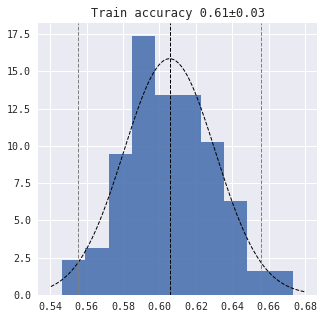

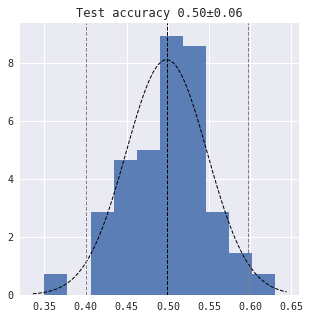

In [9]:
@n_experiments(100)
def model_fair(m, n_samples, n_features, train_size):
    X = np.random.normal(size=(n_samples, n_features))
    y = np.sign(np.random.normal(size=(n_samples)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    m.fit(X_train, y_train)
    y_hat_train = m.predict(X_train)
    y_hat_test = m.predict(X_test)
    acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
    acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
    return acc_train, acc_test


res_train, res_test = model_fair(
    m=LogisticRegression(),
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

Accuracy train=0.82±0.03 test=0.50±0.09


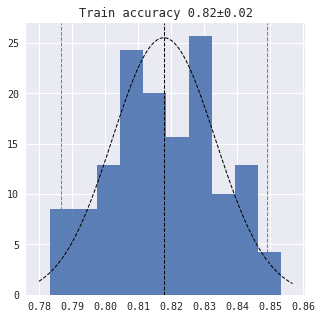

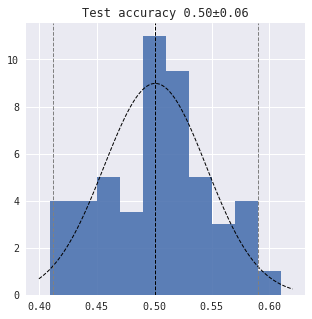

In [10]:
res_train, res_test = model_fair(
    m=HistGradientBoostingClassifier(**hgb_params),
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

Accuracy train=1.00±0.00 test=0.50±0.10


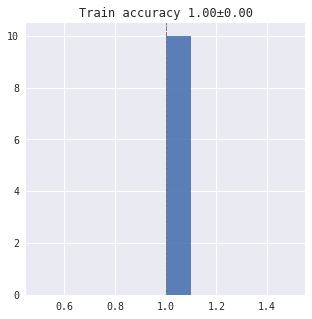

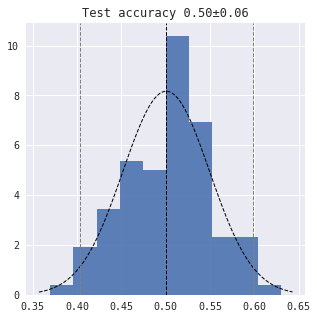

In [11]:
res_train, res_test = model_fair(
    m=MLPClassifier(**mlp_params),
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

### Hyperparameter Overtuning
(tuning on test data)

**Story:** You've finished your experiment and checked the results on test data. The results are underwhelming... but then you had a thought "But what if I tweaked that smoothing parameter just a little? I think that'll do the trick!" You repeat it multiple times with different sets of parameters and then choose the best model.

**Results:**
- If we tune model hyperparameters on test data, we raise mean accuracy to **55%** on test data!
- ...and we have a 10% chance to get **>60%** accuracy.

In [12]:
@n_experiments(100)
def model_with_tuning(m, params_list, n_samples, n_features, train_size):
    X = np.random.normal(size=(n_samples, n_features))
    y = np.sign(np.random.normal(size=(n_samples)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    results = []
    for params in params_list:
        m.set_params(**params)
        m.fit(X_train, y_train)
        y_hat_train = m.predict(X_train)
        y_hat_test = m.predict(X_test)
        acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
        acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
        results.append({"params": params, "train_score": acc_train, "test_score": acc_test})
    results = sorted(results, key=lambda x: x["test_score"])
    return results[-1]["train_score"], results[-1]["test_score"]

Accuracy train=0.79±0.13 test=0.55±0.08


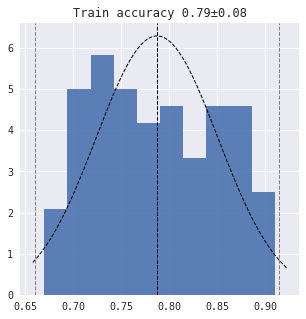

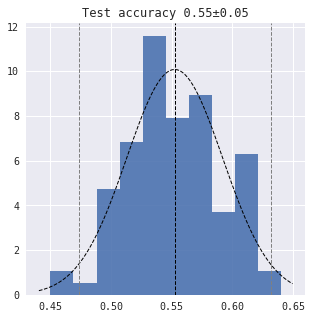

In [13]:
res_train, res_test = model_with_tuning(
    m=HistGradientBoostingClassifier(**hgb_params),
    params_list=[{"learning_rate": 1. / (i + 2)} for i in range(20)],
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

### Refitting
(refitting a model again and again)

**Story:** You've finished your experiment and checked the results on test data. The results are underwhelming... but then you think "What if I was just unlucky and SGD happened to find a weird local minimum? Let's try again!" You refit your model multiple times until you find a fit that works well on the test data. 

**Results:**
- If we refit a stochastic model multiple times, we raise mean accuracy to **57%** on test data!
- ...and we have a 10% chance to get **>62%** accuracy.

In [14]:
@n_experiments(100)
def model_with_refitting(m, n_fits, n_samples, n_features, train_size):
    X = np.random.normal(size=(n_samples, n_features))
    y = np.sign(np.random.normal(size=(n_samples)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    results = []
    for i in range(n_fits):
        m.set_params(random_state=i)
        m.fit(X_train, y_train)
        y_hat_train = m.predict(X_train)
        y_hat_test = m.predict(X_test)
        acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
        acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
        results.append({"fit": i, "train_score": acc_train, "test_score": acc_test})
    results = sorted(results, key=lambda x: x["test_score"])
    return results[-1]["train_score"], results[-1]["test_score"]

Accuracy train=1.00±0.00 test=0.57±0.08


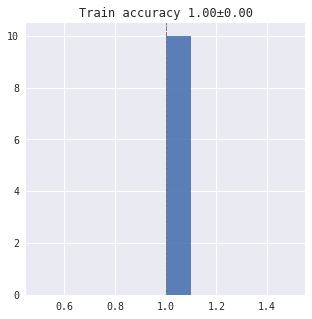

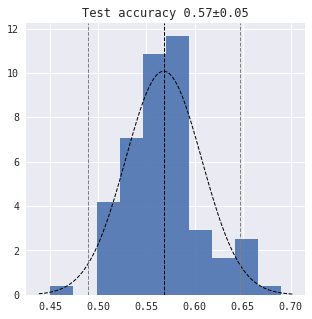

In [15]:
res_train, res_test = model_with_refitting(
    m=MLPClassifier(**mlp_params),
    n_fits=20,
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

### Post-selecting features
(selecting features based on the test set)

**Story:** You've finished your experiment and checked the results on test data. The results are underwhelming... but then your boss comes and says "Hey, I think your should definitely try to include these *cool* features. And you can remove these ones, they don't have any fundamental meaning. I think that'll do the trick!" You repeat it multiple times with different sets of features, and then choose the set of features with the best performance.

**Results:**
- By "post-selecting" features, we raise mean accuracy to **58%** on test data!
- ...and we have a 10% chance to get **>62%** accuracy.

In [16]:
@n_experiments(100)
def model_with_feature_selection(m, features_list, n_samples, n_features, train_size):
    X = np.random.normal(size=(n_samples, n_features))
    y = np.sign(np.random.normal(size=(n_samples)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    results = []
    for features in features_list:
        X_train_ = X_train[:, features]
        X_test_ = X_test[:, features]
        m.fit(X_train_, y_train)
        y_hat_train = m.predict(X_train_)
        y_hat_test = m.predict(X_test_)
        acc_train = 1 - np.mean(np.abs((y_hat_train - y_train))) / 2
        acc_test = 1 - np.mean(np.abs((y_hat_test - y_test))) / 2
        results.append({"features": features, "train_score": acc_train, "test_score": acc_test})
    results = sorted(results, key=lambda x: x["test_score"])
    return results[-1]["train_score"], results[-1]["test_score"]

Accuracy train=0.57±0.05 test=0.58±0.06


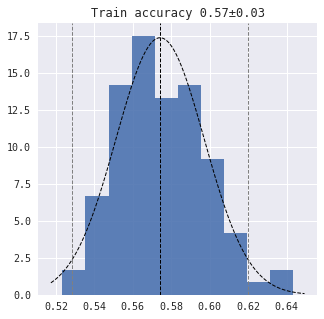

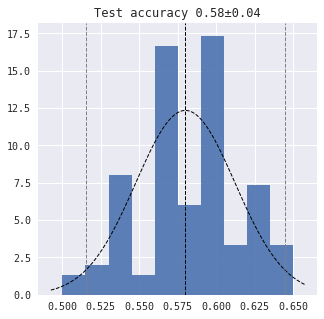

In [17]:
res_train, res_test = model_with_feature_selection(
    m=LogisticRegression(),
    features_list=[
        np.random.choice([False, True], size=20) for _ in range(20)
    ],
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

Accuracy train=0.77±0.05 test=0.58±0.06


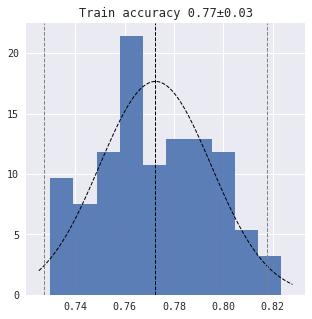

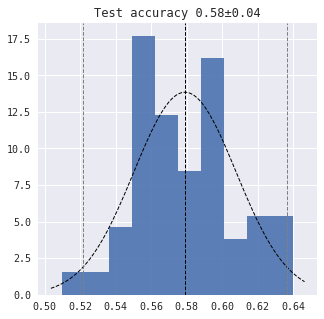

In [18]:
res_train, res_test = model_with_feature_selection(
    m=HistGradientBoostingClassifier(**hgb_params),
    features_list=[
        np.random.choice([False, True], size=20) for _ in range(20)
    ],
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

### Post-selecting targets
**Story:** You've finished your experiment and checked the results on test data. The results are underwhelming... but then your colleague Jess says "Hey, why won't you check your model on all the other markets? Maybe it'll work on at least one of them. I think that'll do the trick!" You test the model on all available markets, and then choose the market with the best performance.

**Results:**
- By "post-selecting" features, we raise mean accuracy to **59%** on test data!
- ...and we have a 10% chance to get **>62%** accuracy.

In [19]:
@n_experiments(100)
def model_with_target_selection(m, n_targets, n_samples, n_features, train_size):
    X = np.random.normal(size=(n_samples, n_features))
    y = np.sign(np.random.normal(size=(n_samples, n_targets)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    results = []
    for i in range(n_targets):
        y_train_ = y_train[:, i]
        y_test_ = y_test[:, i]
        m.fit(X_train, y_train_)
        y_hat_train = m.predict(X_train)
        y_hat_test = m.predict(X_test)
        acc_train = 1 - np.mean(np.abs((y_hat_train - y_train_))) / 2
        acc_test = 1 - np.mean(np.abs((y_hat_test - y_test_))) / 2
        results.append({"target": i, "train_score": acc_train, "test_score": acc_test})
    results = sorted(results, key=lambda x: x["test_score"])
    return results[-1]["train_score"], results[-1]["test_score"]

Accuracy train=0.61±0.05 test=0.59±0.05


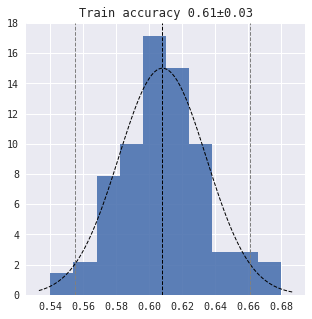

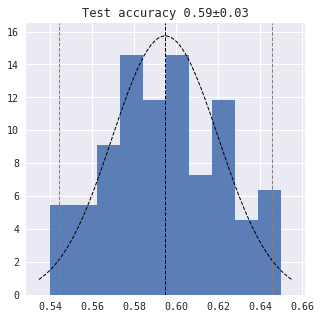

In [20]:
res_train, res_test = model_with_target_selection(
    m=LogisticRegression(),
    n_targets=20,
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

Accuracy train=0.82±0.04 test=0.59±0.05


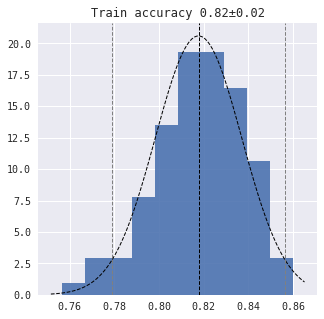

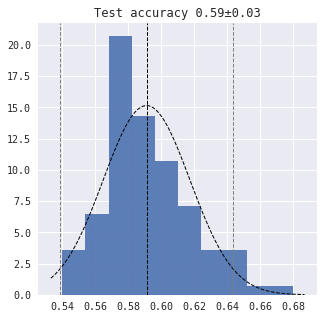

In [21]:
res_train, res_test = model_with_target_selection(
    m=HistGradientBoostingClassifier(**hgb_params),
    n_targets=20,
    n_samples=n_samples,
    n_features=n_features,
    train_size=train_size,
)
experiment_summary(res_train, res_test)

### Conclusion
- If you only check results on test data once, you'll get realistic results (on average).
- Due to sheer luck (or, rather, misfortune), you **may** get optimistic results even if you do everything right. However, it is unlikely with a sufficiently large dataset (see below).
- If you use test data to improve your model in any way (e.g., hyperparameter tuning, feature or target selection), you **will** get optimistic results (on average). This blissful ignorance will only break when your model hits production and meets some actual out-of-sample data.

## Size (of the sample) matters!
**Question:** Previous results were for 400 data samples. What would happend if you had less (more) data?

**Answer:** Basically, the more data you have, the more difficult it is to get over-optimistic even if your experiment is badly designed. The opposite is true as well.

In [22]:
results = {}
for _n_samples in (100, 200, 400, 800, 1600):
    res_train, res_test = model_with_feature_selection(
        m=LogisticRegression(),
        features_list=[
            np.random.choice([False, True], size=20) for _ in range(20)
        ],
        n_samples=_n_samples,
        n_features=n_features,
        train_size=train_size,
    )
    results[_n_samples] = {"train": res_train, "test": res_test}
    print(".", end="")

.....

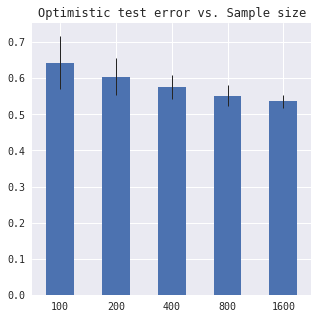

In [23]:
results_df = pd.DataFrame({
    "mean": pd.Series(
        {k: np.mean(v["test"]) for k, v in results.items()}
    ),
    "std": pd.Series(
        {k: np.std(v["test"]) for k, v in results.items()}
    )
})
results_df["mean"].plot(
    kind="bar", yerr=results_df["std"], title="Optimistic test error vs. Sample size", rot=0
)
_ = _    

**Just a fun fact:** You can notice that the test error convergence rate is $n^\frac{1}{2}$.

In [24]:
results_df["std"].shift(1) / results_df["std"]

100          NaN
200     1.439606
400     1.522544
800     1.153949
1600    1.533961
Name: std, dtype: float64

## Some tools to spot overfitting

In [25]:
# work in progress